# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available for someone or something else.

## 0. Get Setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
ERROR: Operation cancelled by user
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 4183 (delta 63), reused 109 (delta 41), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 38.42 MiB/s, done.
Resolving deltas: 100% (2434/2434), done.
Updating files: 100% (248/248), done.


In [9]:
# prompt: setup device agnostic code

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 1. Getting Data

The dataset we're going to use for deploying a FoodVision mini model is...



In [10]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [11]:
# Setup training and test paths
train_dir_20_percent = data_20_percent_path / "train"
test_dir_20_percent = data_20_percent_path / "test"

train_dir = train_dir_20_percent
test_dir =  test_dir_20_percent

## 2. Foodvision Mini model deployment experiment outline

###3 Questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function ?

**Foodvision Mini ideal use case:** A model that performs well and fast.

* Performs well : 95%+ Accuracy
* Fast : As close to real time (or faster) as possible (30FPS+ or 30ms latency)

To try and achive these goals we are going to build 2 model experiments:

1. EffNetB2 feature extractor
2. ViT feature extractor

## 3. Creating an EffNetB2 Extractor

In [12]:
# import torchvision
# set_seeds()
# # 1. Setup pretrained model
# effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# # 2. Get the transforms
# effnetb2_transforms = effnetb2_weights.transforms()

# # 3. Setup a pretrained model instance
# effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device) # Could also use weights = "DEFAULT"

# # 4. Freeze the base layers in the model
# for param in effnetb2.parameters():
#     param.requires_grad = False

# # 5. change the classifier head
# effnetb2.classifier = nn.Sequential(
#     nn.Dropout(p=0.3, inplace=True),
#     nn.Linear(in_features=1408, out_features=3, bias=True)
# ).to(device)

In [13]:
# from torchinfo import summary

# # Print a summary of the model
# summary(model=effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [14]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [15]:
# effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
#                                                       seed=42)

In [16]:
# from torchinfo import summary

# # Print a summary of the model
# summary(model=effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [17]:
# # Setup DataLoaders
# from going_modular.going_modular import data_setup
# train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
#                                                                                                  test_dir=test_dir,
#                                                                                                  transform=effnetb2_transforms,
#                                                                                                  batch_size=32)

In [18]:
# len(train_dataloader_effnetb2), len(test_dataloader_effnetb2)

### 3.3 Training effnetb2 feature extractor

In [19]:
# from going_modular.going_modular import engine

# # Setup optimizer
# optimizer = torch.optim.Adam(params=effnetb2.parameters(),
#                              lr=1e-3)
# # Setup loss function
# loss_fn = torch.nn.CrossEntropyLoss()

# # Set seeds for reproducibility and train the model
# set_seeds()
# effnetb2_results = engine.train(model=effnetb2,
#                                 train_dataloader=train_dataloader_effnetb2,
#                                 test_dataloader=test_dataloader_effnetb2,
#                                 epochs=10,
#                                 optimizer=optimizer,
#                                 loss_fn=loss_fn,
#                                 device=device)

### 3.4 Inspect the models loss curves

In [20]:
# from helper_functions import plot_loss_curves
# plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [21]:
# from going_modular.going_modular import utils

# # Save the model
# utils.save_model(model=effnetb2,
#                  target_dir="models",
#                  model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

### 3.6 Inspecting the size of our EffNetB2 feature extractor

In [22]:
# from pathlib import Path

# # Gt the model size in bytes and convert to megabytes

# pretrained_effnetb2_model_size = Path("/content/models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
# print(f"EffNetB2 model size: {pretrained_effnetb2_model_size:.2f} MB")

### 3.7 Collecting EffNetB2 feature extractor stats

In [23]:
# # Count number of parameters in effnetb2
# effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
# effnetb2_total_params

In [24]:
# # Create a Dict with effnetb2 statistics
# effnetb2_stats = {
#     "test_loss" : effnetb2_results["test_loss"][-1],
#     "test_acc" : effnetb2_results["test_acc"][-1],
#     "model_size" : pretrained_effnetb2_model_size,
#     "params_count" : effnetb2_total_params
# }
# effnetb2_stats


## 4. Creating a ViT Feature extractor

In [25]:
# # Check out vision transformer heads layer
# vit = torchvision.models.vit_b_16()
# vit.heads


In [26]:
# def create_vit_model(num_classes:int=3,
#                      seed:int=42):
#     # Create ViT_B_16 weights transforms and models
#     weights = torchvision.models.ViT_B_16_Weights.DEFAULT
#     transforms = weights.transforms()
#     model = torchvision.models.vit_b_16(weights=weights)

#     for param in model.parameters():
#         param.requires_grad = False

#     # Change the classifier head
#     torch.manual_seed(seed)
#     model.heads = nn.Sequential(
#         nn.Linear(in_features=768, out_features=num_classes)
#     )
#     # return model, transforms

In [27]:
# vit, vit_transforms = create_vit_model()
# vit_transforms

In [28]:
# from torchinfo import summary

# # Print a summary of the model
# summary(model=vit,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT feature extractor

In [29]:
# train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
#                                                                                        test_dir=test_dir_20_percent,
#                                                                                        transform=vit_transforms,
#                                                                                        batch_size=32)
# train_dataloader_vit, test_dataloader_vit, class_names

### 4.3 Training a ViT feature extractor

In [30]:
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

In [31]:
# from going_modular.going_modular import engine
# vit_results = engine.train(model=vit,
#                            train_dataloader=train_dataloader_vit,
#                            test_dataloader=test_dataloader_vit,
#                            optimizer=optimizer,
#                            loss_fn=loss_fn,
#                            epochs=10,
#                            device=device)

### 4.3 Plot Loss Curves of ViT Feature Extractor

In [32]:
# from helper_functions import plot_loss_curves
# plot_loss_curves(vit_results)

### 4.4 Saving ViT Feature Extractor

In [33]:
# from going_modular.going_modular import utils
# utils.save_model(model=vit,
#                  target_dir="/content/models",
#                  model_name="vit.pth")

### 4.5 Checking the Size of our ViT Feature Extractor

In [34]:
# from pathlib import Path
# pretrained_vit_model_size = Path("/content/models/vit.pth").stat().st_size / (1024*1024)
# print(f"The size of our ViT Feature Extractor is : {pretrained_vit_model_size} MB")

### 4.6 Collecting ViT feature extractor stats

In [35]:
# vit_total_params = sum(torch.numel(param) for param in vit.parameters())
# vit_total_params

In [36]:
# # Create a Dict with vit statistics
# vit_stats = {
#     "test_loss" : vit_results["test_loss"][-1],
#     "test_acc" : vit_results["test_acc"][-1],
#     "model_size" : pretrained_vit_model_size,
#     "params_count" : vit_total_params
# }
# vit_stats

## 5. Making predicitions with our trained models and timing them.

In [37]:
# from pathlib import Path
# # Get all test data paths
# test_data_paths = list(Path(test_dir_20_percent).glob("*/*.jpg"))

### 5.1 Creating a function to make predicitions across the test dataset

In [38]:
# import pathlib
# import torch

# from typing import Dict, List
# from timeit import default_timer as timer
# from tqdm.auto import tqdm
# from PIL import Image

# # 1. Create a  function that takes a list of path
# def pred_and_store(paths: List[pathlib.Path],
#                    model:torch.nn.Module,
#                    transform: torchvision.transforms,
#                    class_names:List[str],
#                    device: str = "cuda" if torch.cuda.is_available else "cpu") -> List[Dict]:
#     # 2. Create an Empty List
#     pred_list = []

#     # 3. Loop through the target input paths
#     for path in tqdm(paths):

#         # 4. Create an empty Dictionary for each sample
#         pred_dict = {}

#         # 5. Get the sample path and ground truth class from the filepath
#         pred_dict["image_path"] = path
#         class_name = path.parent.stem
#         pred_dict["class_name"] = class_name

#         # 6. Start the predicitions timer
#         start_time = timer()

#         # 7. Open the image
#         img = Image.open(path)

#         # 8. Transform the image and add a batch dimension
#         transformed_image = transform(img).unsqueeze(0).to(device)

#         # 9. Activate eval mode
#         model = model.to(device)
#         model.eval()

#         # 10. Turn on inference mode and perform a forward pass
#         with torch.inference_mode():
#             pred_logit = model(transformed_image)
#             pred_prob = torch.softmax(pred_logit, dim=1)
#             pred_label = torch.argmax(pred_prob, dim=1)
#             pred_class = class_names[pred_label.cpu()] # Hardcode predicition class to be on CPU

#             # 11. Add the pred prob + pred class to empty Dict from step 4
#             pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
#             pred_dict["pred_class"] = pred_class

#             # 12. End the predicition timer
#             end_time = timer()
#             pred_dict["time_for_pred"] = round(end_time - start_time, 4)

#         # 13. See if the predicted class matches the ground truth class
#         pred_dict["correct"] = class_name == pred_class

#         # 14. Append the updated dictionary to the list of predictions
#         pred_list.append(pred_dict)
#     # 15. Return pred_list
#     return pred_list

### 5.2 Making and timing predicitions with EffNetB2

In [39]:
# # Make predicitions across test dataset with EffNetB2

# effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
#                                           model=effnetb2,
#                                           transform=effnetb2_transforms,
#                                           class_names=class_names,
#                                           device="cpu")

In [40]:
# effnetb2_test_pred_dicts[:3]

In [41]:
# # Turn the test pred dicts into a Dataframe
# import pandas as pd
# effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
# effnetb2_test_pred_df.head()

In [42]:
# # Check the number of correct predicts

# effnetb2_test_pred_df.correct.value_counts()

In [43]:
# # Find the average time per predict
# effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
# print(f"EffnetB2 average time for predicition: {effnetb2_average_time_per_pred} seconds")

In [44]:
# # Add time per pred to EffNetB2 Stats dict
# effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
# effnetb2_stats

> **Note:** Predicition times will vary depending on the hardware you're using... so generally the faster your compute , the faster the predicitions will happen.

In [45]:
# device

### 5.2 Making and timing predicitions with ViT

In [46]:
# # Make list of prediction dictionaries with vit feature extractor model on test images
# vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
#                                      model=vit,
#                                      transform=vit_transforms,
#                                      class_names=class_names,
#                                      device="cpu")

In [47]:
# # Check the first couple of ViT predicitions
# vit_test_pred_dicts[:3]

In [48]:
# # Turn vit_test_pred_dicts ino a DataFrame
# import pandas as pd
# vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
# vit_test_pred_df.head()

In [49]:
# # See how many correct ?
# vit_test_pred_df.correct.value_counts()

In [50]:
# # Calculate average time per perdiction for ViT model
# vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
# print(f"ViT average time for predicition: {vit_average_time_per_pred} seconds")

In [51]:
# # Add average time per prediction to ViT stats
# vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
# vit_stats

 ## 6. Comparing model results, prediction times and size

In [52]:
# # Turn stat dictionaries into dataframe
# df = pd.DataFrame([effnetb2_stats, vit_stats])

# # Add a column for model names
# df["model"] = ["EffNetB2", "ViT"]

# # Convert accuracy to percentages
# df["test_acc"] = round(df["test_acc"]*100, 2)

# df

Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better) - EffNetB2
* `model_size` (for mobile device generally lower is better) - EffNetB2
* `time_per_pred_cpu` (lower is better, will be higly dependent on the hardware you're running on.) - EffNetB2

Both models fail to achieve our goal of 30FPS... however we could always use EffNetB2 and see how it goes

In [53]:
# # Compare ViT to Effnetb2 across different characteristics
# pd.DataFrame(data = df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"],
#              columns = ["ViT to EffNetB2 ratios"]).T

### 6.1 Visualizing the speed vs. performance tradeoff

We can do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across accuracy and predicition time.
2. Add titles and labels
3. Annotate the samples on the scatter plot
4. Create a legend based on model sizes.

In [54]:
# # 1. Create a  plot from model comparison DattaFrame
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(12, 8))
# scatter = ax.scatter(data=df,
#                      x="time_per_pred_cpu",
#                      y="test_acc",
#                      c=["blue", "orange"],
#                      s="model_size")

# # 2. Add titles and labels
# ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
# ax.set_xlabel("Prediction Time (seconds)", fontsize=14)
# ax.set_ylabel("Accuracy (%)", fontsize=14)
# ax.tick_params(axis="both", labelsize=12)
# ax.grid(True)

# # 3. Annotate the samples on the scaatter plot so we know what's going on
# for index , row in df.iterrows():
#     ax.annotate(text=row["model"],
#                 xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
#                 size=12)
# # 4. Create a legend based on the model sizes
# handels, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
# model_size_legend = ax.legend(handels, labels,loc="lower right" , title="Model Size")

# # Save the figure
# plt.savefig("model_comparison.png")

## 7. Bringing FoodVision Mini to life ny creating a Gradio demo

In [55]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.1 MB/s eta 0:00:00
Gradio version: 4.42.0


### 7.1 Gradio overview

Gradio helps you create machine learning demos

Why Create demo ?

So other people can try our models and we can test them in the rel world

Deployment is as important as training.

So the overall premise of Gradio is to : inputs -> function/model -> outputs.

### 7.2 Creating a function to map our inputs into outputs

In [56]:
# # Put our model on the cpu
# effnetb2 = effnetb2.to("cpu")

# # Check the device
# next(iter(effnetb2.parameters())).device

NameError: name 'effnetb2' is not defined

Let's create a function called `predict()` to go from :

```
images of food -> ML model (EffNetB2) -> outputs (food class)
```

In [57]:
from typing import Tuple, Dict
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()
  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # Unsqueeze == Add batch dimension on 0th index
  # Put model into eval mode, make predicitions
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the predicition logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a predicition label and predicition probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [60]:
# from timeit import default_timer as timer
# import random
# from PIL import Image

# # Get a list of all test image filepaths
# test_data_paths = list(Path(test_dir_20_percent).glob("*/*.jpg"))
# # Randomly select a test image path
# random_image_path = random.sample(test_data_paths, k=1)[0]

# # Open the target image
# image = Image.open(random_image_path)
# print(f"[INFO] predicitong on image at path : {random_image_path}")

# # Predict on the target image and print out the outputs
# pred_dict, pred_time = predict(img=image)
# print(pred_dict)
# print(pred_time)

NameError: name 'Path' is not defined

### 7.3 Creating a list  of example images


In [ ]:
# # Create a list of our example inputs to our Gradio

# example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
# example_list

### 7.4 Build a Gradio interface

**Use `gr.interface`**

In [61]:
# import gradio as gr

# # Create title,, description and articcle
# title = "FoodVision Mini :D"
# description = "An [EfficientNetB2 Feature Extractor](https://pytorch.org/vision/stable/models/efficientnet.html) computer vision model to classify images as Pizza, Steak and Sushi."
# article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# # Create the Gradio demo
# demo =gr.Interface(fn=predict,
#                   inputs=gr.Image(type="pil"),
#                   outputs=[gr.Label(num_top_classes=3, label=("Predicitions")),
#                            gr.Number(label="Prediction Time (s)")],
#                   examples=example_list,
#                   title=title,
#                   description=description,
#                   article=article)
# # Launch the demo!
# demo.launch(debug=False, # Print errors locally?
#             share=True)

NameError: name 'example_list' is not defined

## 8. Turning our FoddVision Mini Gradio demo into a deployable app

Our Gradio demo's are fantastic but they expire within 72 hours...

to Fix this we're going to prepare our app files so we can host them into Hugging Face Spaces.

### 8.1 What is HuggingFace Spaces ?

>Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If Github is a place to show your coding ability, Hugging Face is a place to show your Machine Learning Ability. (Through sharing ML Demos)

### 8.2 Deployed Gradio App Structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy demo
```

By the end our file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```



### 8.3 Creating a `demos` folder to store our FoodVision app files

In [62]:
# import shutil
# from pathlib import Path

# # Create FoodVision Mini demo Path
# foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# # Remove files that might exist and create a new directory
# if foodvision_mini_demo_path.exists():
#   shutil.rmtree(foodvision_mini_demo_path)
#   foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
# else:
#   foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test dataset

In [ ]:
# import shutil
# from pathlib import Path

# # Create an examples directory
# foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
# foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# # Collect three random test dataset image paths
# foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
#                             Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
#                             Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# # Copy the three images to the examples directory
# for example in foodvision_mini_examples:
#   destination = foodvision_mini_examples_path / example.name
#   print(f"[INFO] Copying {example} to {destination}")
#   shutil.copy2(src=example,
#                dst=destination)

Let's now verify that we can get a list of lists from our `examples/` directory.

In [ ]:
# import os

# # Get  example filepaths in a list of lists
# example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
# example_list

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo Directory

In [63]:
# import shutil

# # Create a Source path for our Traget model
# effnetb2_foodvision_mini_model_path = "models/effnetb2.pth"

# # Create a destination Path
# effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# # Try to move the model file
# try:
#   print(f"[INFO] attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination} ")

#   # Move the model
#   shutil.move(src=effnetb2_foodvision_mini_model_path,
#               dst=effnetb2_foodvision_mini_model_destination)
#   print(f"[INFO] Model moved succesfully.")
# # If the model has already been moved, check if it exists.
# except:
#   print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps it's already been moveed?")
#   print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] attempting to move models/effnetb2.pth to demos/foodvision_mini/effnetb2.pth 
[INFO] No model found at models/effnetb2.pth, perhaps it's already been moveed?
[INFO] Model exists at demos/foodvision_mini/effnetb2.pth: False


### 8.6 Turning off EffNetB2 model into a Python script (`model.py`)

We have a saved `.pth` model `state_dict` and want to load it into a model instance

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [91]:
%%writefile /content/demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # 1, 2, 3 Create EffnetB2 weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all Layers
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

Writing /content/demos/foodvision_mini/model.py


In [64]:
# try:
#   from demos.foodvision_mini import model
#   print(f"[INFO] Importing was a success!!")
# except:
#   print(f"[INFO] It seems like our model script isn't importing quite well :(")

# # effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
# # effnetb2_model

[INFO] It seems like our model script isn't importing quite well :(


### 8.7 Turning our FoodVision Mini Gradio app into an Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + Launch command


In [ ]:
# %%writefile demos/foodvision_mini/app.py
# ### 1. Imports and class names setup ###
# import gradio as gr
# import os
# import torch

# from model import create_effnetb2_model
# from timeit import default_timer as timer
# from typing import Tuple, Dict

# # Setup class names
# class_names = ["pizza", "steak", "sushi"]

# ### 2. Model and transforms preparation ###
# effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=leen(class_names))

# # Load save weights
# effnetb2.load_state_dict(
#     torch.load(
#         f="effnetb2.pth",
#         map_location = torch.device("cpu") # Load the model to the CPU
#     )
# )

# ### 3. Predict Function ###

# def predict(img) -> Tuple[Dict, float]:

#   start_time = timer()

#   img = effnetb2_transforms(img).unsqueeze(0) # Unsqueeze == Add batch dimension on 0th index

#   effnetb2.eval()
#   with torch.inference_mode():
#     pred_probs = torch.softmax(effnetb2(img), dim = 1)

#   pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

#   end_time = timer()
#   pred_time = round(end_time - start_time, 4)

#   return pred_labels_and_probs, pred_time

# ### 4. Gradio App ###

# # Create title,, description and articcle
# title = "FoodVision Mini :D"
# description = "An [EfficientNetB2 Feature Extractor](https://pytorch.org/vision/stable/models/efficientnet.html) computer vision model to classify images as Pizza, Steak and Sushi."
# article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# # Create example list
# example_list = [["examples/" + example] for example in os.listdir("examples")]
# # Create the Gradio demo
# demo =gr.Interface(fn=predict,
#                   inputs=gr.Image(type="pil"),
#                   outputs=[gr.Label(num_top_classes=3, label=("Predicitions")),
#                            gr.Number(label="Prediction Time (s)")],
#                   examples=example_list,
#                   title=title,
#                   description=description,
#                   article=article)
# # Launch the demo!
# demo.launch(debug=False, # Print errors locally?
#             share=True)

### 8.8 Creating a requirements file for FoodVision Mini `requirements.txt`

The thre main ones are:
* `torch`
* `torchvision`
* `gradio`

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt

torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

## 9. Deploying our FoodVision Mini app into HuggingFace Spaces

### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [ ]:
# !ls demos/foodvision_mini

In [95]:
# # Chaange into the foodvision_mini directory and zip it from the inside
# !cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" " *__pycache__*" "*ipynb_checkpoints*"

In [97]:
# # Download
# try:
#   from google.colab import files
#   files.download("demos/foodvision_mini.zip")
# except:
#   print(f"Not running in Google Colab, can't use google.colab.files.download(), please Download manually...")

### 9.2 Running our Gradio demo app locally

### 9.3 Uploading our FoodVision Mini Gradio Demo to HuggingFace Spaces

We can also share our App by embedding it.

In [ ]:
#  from IPython.display import IFrame

#  # Embed foodvision mini Gradio demo
#  IFrame(src="https://hf.space/embed/itserphan/FoodVision_Mini/+", width=900, height=750)

## 10. Creating FoodVision Big !

 ### 10.1 Creating a model for FoodVision Big. + transforms

In [65]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 52.9MB/s]


In [66]:
from torchinfo import summary

# Print a summary of the model
summary(model=effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [67]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Since we're working with a larger dataset, we may want to introduce some data augmentation techniques:
* This is because with larger datasets and larger models, overfitting becomes more of a problem
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique.

In [68]:
# Create training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])
food101_test_transforms = effnetb2_transforms
food101_train_transforms, food101_test_transforms

(Compose(
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 )
 ),
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

### 10.2 Getting data for FoodVision Big

In [69]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (~750 x 101 classes == 75750 images)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms, # Performs data Augmentation on the train data
                              download=True)

# Get the testing data (~250 images x 101 classes == 25250)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=food101_test_transforms, # Doesn't perform data Augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:28<00:00, 24010191.55it/s]


Extracting data/food-101.tar.gz to data


In [70]:
# Get Food101 Class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 Dataset for faster experimenting

To do so, let's make a subset of 20% of the data from the Food101 dataset (training and ttesting)

In [71]:
 from torch.utils.data import random_split

In [72]:
def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split lenghts based on the original dataset length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1 # Remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size : {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                  lengths=[length_1, length_2],
                                                                  generator=torch.manual_seed(seed))
  return random_split_1, random_split_2


In [73]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ =  split_dataset(dataset=test_data,
                                                 split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size : 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size : 5050 and 20200


In [74]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets into `Dataloader's`

In [75]:
import torch
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20% test DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)
len(test_dataloader_food101_20_percent), len(train_dataloader_food101_20_percent)

(158, 474)

### 10.5 Training FoodVision Big

Things for training :
* 5 epochs
* Optimizer : `torch.optim.Adam(lr=1e-3)`
* Loss function : `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Why use label smoothing ?
 > label smoothing helps to prevent overfitting (it's a regularization technique)



In [76]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original Food101 Papers Results of 56.4% Acc of the test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


### 10.6 Inspect the loss curves of FoodVision Big model

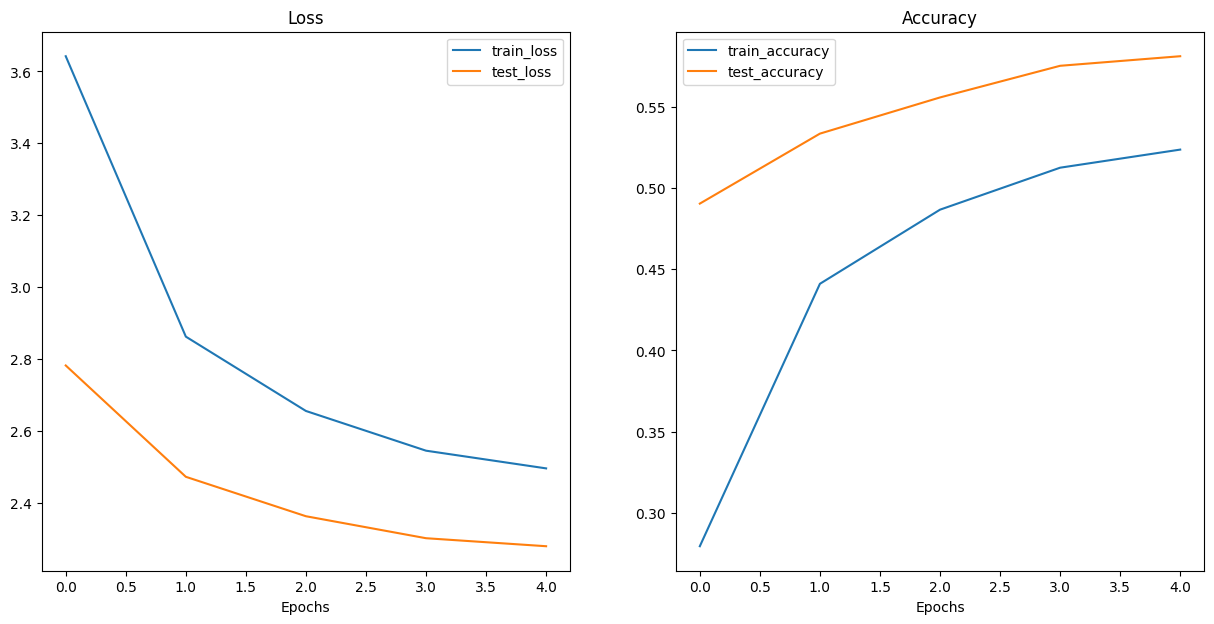

In [77]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and Load FoodVision Big model

In [78]:
from going_modular.going_modular import utils

# Create a model Path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save the foodvision big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [79]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb22_transforms = create_effnetb2_model(num_classes=101)

# Load the model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<ipython-input-79-4b1f8d504c96>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_ex

<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

In [81]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size : {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size : 30 MB


## 11. Turning our FoodVision Big model into a deployable app

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [83]:
from pathlib import Path
# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big Directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision Big demo exmples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True,
                                             exist_ok=True)

### 11.1 Downloading an example image and moving it to the `examples` directory

In [84]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2024-08-28 23:50:51--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2024-08-28 23:50:52 (69.2 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)

In [86]:
# Create path to food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] saving Food101 class names to : {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # New line per class name


[INFO] saving Food101 class names to : demos/foodvision_big/class_names.txt


In [89]:
# Open Food101 Class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [92]:
%%writefile /content/demos/foodvision_big/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # 1, 2, 3 Create EffnetB2 weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all Layers
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    return model, transforms

Writing /content/demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Pythom script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup - for class names, we'll need to import from `class_names.txt` rather than with a Python List.
2. Model and transforms preparation - We'll need to make sure our model is suitable for FoodVision Big
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + Launch command

In [93]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setting up the class names
with open("class_names.txt", "r") as f:
  class_names = [food.strip() for food in f.readlines()]

### 2. Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved Weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location = torch.device("cpu"))
)

### 3. Predict Function ###
def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  img = effnetb2_transforms(img).unsqueeze(0) # Unsqueeze == Add batch dimension on 0th index

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title,, description and articcle
title = "FoodVision Big 🍔👁"
description = "An [EfficientNetB2 Feature Extractor](https://pytorch.org/vision/stable/models/efficientnet.html) computer vision model to classify [101 classes of food from the Food101 Dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]
# Create the Gradio demo
demo =gr.Interface(fn=predict,
                  inputs=gr.Image(type="pil"),
                  outputs=[gr.Label(num_top_classes=5, label=("Predicitions")),
                           gr.Number(label="Prediction Time (s)")],
                  examples=example_list,
                  title=title,
                  description=description,
                  article=article)
# Launch the demo!
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a Requirements file for Foodvision Big

In [94]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==2.6.4
numpy==1.21.5

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our Foodvision Big app files

In [96]:
# Change into the foodvision_big directory and zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" " *__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 48%)
  adding: requirements.txt (deflated 6%)


In [98]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please Download manually...")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 11.7 Deploying our FoodVision Big model app to Hugging Face Spaces